In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import  MiniBatchKMeans
import numpy as np
import pandas as pd
from joblib import dump, load

%autosave 0 

Autosave disabled


In [2]:


class HMM (object):
             def __init__(self,A,B,PI):
                 self.A=A
                 self.B=B
                 self.PI=PI   
def viterbi(obs,Modelo1,PI):
    
    delta=np.zeros((len(obs)+1,len(Modelo1.A)))
    phi=np.zeros((len(obs)+1,len(A)))+666
    path =np.zeros(len(obs)+1)
    T=len(obs)
    Modelo1.PI = PI
    delta[0,:]= Modelo1.PI * Modelo1.B[:,obs[0]]
    phi[0,:]=666
    for t in range(len(obs)):
        for j in range(delta.shape[1]):

            delta [t+1,j]=np.max(delta[t] * A[:,j]) * B[j,obs[t]]
            phi[t+1,j]= np.argmax(delta[t] * A[:,j])
    path[T]=int(np.argmax(delta[T,:]))
    for i in np.arange(T-1,0,-1):
        #print (i,phi[i+1,int(path[i+1])])
        path[i]=phi[i+1,int(path[i+1])]
    return(path)
def cuantizar_xy(xy, cc):
    xycuant=cc
    out=np.power(xycuant-xy,2).sum(axis=1).argmin()
    return out
    
def path_to_xy(path,ccxy):
    estimated= pd.DataFrame(path.astype(int).T)
    estimated.columns=[['Path_vit']]
    estimated['xcuant'] = estimated['Path_vit'].apply(lambda x: ccxy[x,0])
    estimated['ycuant'] = estimated['Path_vit'].apply(lambda x: ccxy[x,1])                                
    return (estimated)
def quantized(xyth,ccxyth):
    xythcuant=np.argmin(np.linalg.norm(xyth-ccxyth,axis=1))
    x,y=ccxyth[xythcuant,:2]
    return ((x,y),(xythcuant))



In [3]:
def Markov_A_2_grafo(A,ccxyth):
    dists=np.zeros(A.shape)
    for i in range(A.shape[0]):
        for j in range (A.shape[1]):
            if A[i,j]!=0 :
                dists[i,j]= np.linalg.norm(ccxyth[i]-ccxyth[j])    
    
    
    con = np.where(dists==0,np.inf,dists)
    graphe2=grafo(ccxyth,con)
    return graphe2


class node(object):
    def __init__(self,x,y):
        self.x=x
        self.y=y
        
        
class grafo (object):
             def __init__(self,nodos,conec):
                 self.nodos=nodos
                 self.conec=conec        

def dijkstra(nodoinicial,nodofinal,graphe):
    

    numnodos= len(graphe.nodos)
    con = graphe.conec
    D= np.ones(numnodos)*np.inf
    Prv= np.ones(numnodos)*np.inf
    V= np.zeros(numnodos)
    a = nodoinicial
    D[a]=0
    Prv[a]=0
    Prv[np.where(con[a]!=np.inf)]=a
    V[a]=1
    Dacc=D[a]
    ########
    D=np.minimum(D,con[a]+D[a])
    cont=0
    sucess=False
    while(sucess==False):
        a = np.argmin(D+np.where (V==1,np.inf, V))
        Dacc=D[a]
        Prv[np.where(D>(con[a]+Dacc) )]=a
        V[a]=1
        D=np.minimum(D,con[a]+Dacc)
        if (a== nodofinal):
            print("RUTA CALCULADA ")
            sucess=True
    rutainv=[]
    rutainv.append(nodofinal)
    while(rutainv[-1]!=nodoinicial):
        prv=Prv[int(rutainv[-1])]
        rutainv.append(prv)

    ruta=[]
    for n in reversed(rutainv):
        ruta.append(n)
    return(ruta)


In [4]:
ccxyth,ccvk=np.load('ccxyth.npy'),np.load('ccvk.npy')
A,B,PI = np.load('A.npy'),np.load('B.npy'),np.load('PI.npy')
Modelo= HMM(A,B,PI)


In [5]:
calculate=True
noise_mean=0
noise_std=.1
if (calculate):
    datamugroso=pd.read_csv('pddata.csv')
    data= datamugroso.iloc[:,1:]
    x_noise,y_noise,th_noise=np.zeros(data.x.shape),np.zeros(data.x.shape),np.zeros(data.x.shape)
    x_noise[0],y_noise[0],th_noise[0]= data[['x','y','theta']].iloc[0]
    cumx,cumth=0,0
    for i in range (len(data)-1):
        delta_movx,delta_movy,delta_movth=(data.x.iloc[i]-data.x.iloc[i+1]),(data.y.iloc[i]-data.y.iloc[i+1]),(data.theta.iloc[i]-data.theta.iloc[i+1])
        if (data.Y.iloc[i]==data.Y.iloc[i+1]):
            x_noise[i+1]=x_noise[i] -   delta_movx +  np.random.normal(noise_mean,noise_std,1) *.1
            y_noise[i+1]=y_noise[i] -   delta_movy +  np.random.normal(noise_mean,noise_std,1) *.1
            th_noise[i+1]=th_noise[i] -   delta_movth +  np.random.normal(noise_mean,noise_std,1) *.1
        else:
            x_noise[i+1]=data.x.iloc[i+1]
            y_noise[i+1]=data.y.iloc[i+1]
            th_noise[i+1]=data.theta.iloc[i+1]
    data['x_noise']= x_noise
    data['y_noise']= y_noise
    data['th_noise']=th_noise


    aus=[]
    xyth=data[['x_noise','y_noise','th_noise']]
    for i in xyth.values:
        _, au= quantized(i , ccxyth)
        aus.append(au)

    data['Y_noise']=aus

    data.to_csv('deltaodom.csv')

    

    


    """diffs=[]
    for i in range(len(data)-1):
        xyth= data[['x','y','theta']].iloc[i].values
        xyth2= data[['x','y','theta']].iloc[i+1].values
        diffs.append(np.linalg.norm(xyth2-xyth))

    diffs.insert(0,0)

    data['deltaPose']=diffs
    data.describe()
    data.to_csv('deltaodom.csv')"""
else:
    datamugroso=pd.read_csv('deltaodom.csv')
    data= datamugroso.iloc[:,1:]
    


#data.head()
data.shape


(8339, 731)

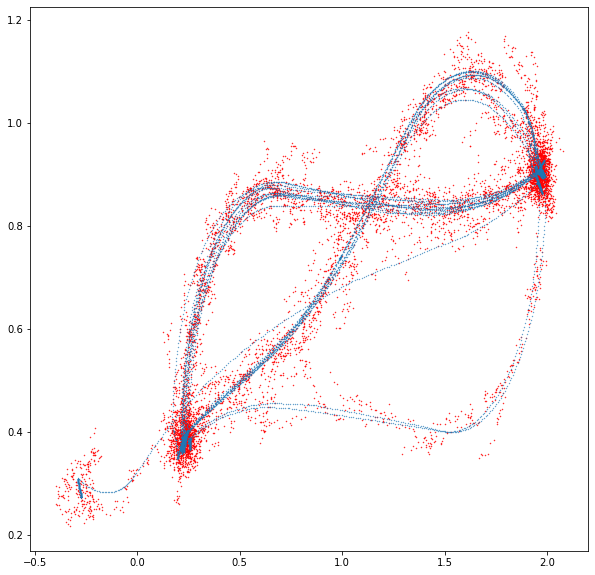

In [6]:


fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.scatter(x=data.x_noise,y=data.y_noise, s=.2 ,c='r' )
ax1.scatter(x=data.x,y=data.y, s=.1)

In [7]:
data

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,x,y,theta,Vk_aff,Y,Vk,x_noise,y_noise,th_noise,Y_noise
0,2.054693,2.047830,2.041082,2.034447,2.027924,2.021512,2.015208,2.009012,2.002921,1.996935,...,-0.271860,0.275444,-3.141338,0,25,20,-0.271860,0.275444,-3.141338,25
1,2.054661,2.047799,2.041052,2.034418,2.027896,2.021484,2.015181,2.008985,2.002895,1.996910,...,-0.271858,0.275449,-3.141368,0,25,20,-0.259249,0.267522,-3.121780,25
2,2.054625,2.047763,2.041017,2.034384,2.027862,2.021451,2.015149,2.008954,2.002864,1.996880,...,-0.271861,0.275439,-3.141301,0,25,20,-0.269173,0.268380,-3.115616,25
3,2.054573,2.047713,2.040967,2.034335,2.027815,2.021405,2.015103,2.008909,2.002821,1.996837,...,-0.271863,0.275436,-3.141260,0,25,20,-0.261997,0.261461,-3.107104,25
4,2.054555,2.047696,2.040951,2.034319,2.027799,2.021389,2.015088,2.008894,2.002806,1.996823,...,-0.271873,0.275432,-3.141204,0,25,20,-0.270148,0.260686,-3.117068,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,1.280440,1.277623,1.274862,1.272156,1.269505,1.266908,1.264364,1.261874,1.259436,1.257050,...,1.983787,0.900634,1.730685,220,27,5,2.018345,0.827458,1.752750,27
8335,1.280432,1.277614,1.274853,1.272146,1.269494,1.266896,1.264351,1.261860,1.259421,1.257034,...,1.983826,0.900628,1.730579,220,27,5,2.021050,0.827822,1.756447,27
8336,1.280418,1.277599,1.274837,1.272130,1.269477,1.266878,1.264333,1.261841,1.259402,1.257014,...,1.983862,0.900624,1.730499,220,27,5,2.025540,0.827055,1.745183,27
8337,1.280403,1.277585,1.274821,1.272113,1.269460,1.266861,1.264315,1.261822,1.259382,1.256994,...,1.983899,0.900619,1.730418,220,27,5,2.031395,0.833362,1.742036,27


In [8]:
old_y=0
ix=0
for y in data.Y:
    if (old_y != y):
        print(old_y,y,ix)
    old_y=y
    ix+=1

0 25 0
25 45 64
45 57 91
57 14 121
14 54 152
54 18 187
18 41 225
41 23 253
23 52 307
52 35 347
35 24 387
24 56 403
56 3 416
3 49 434
49 31 447
31 17 464
17 39 478
39 10 494
10 32 510
32 58 526
58 27 540
27 5 554
5 46 571
46 6 588
6 33 633
33 6 636
6 33 638
33 13 659
13 34 677
34 11 691
11 26 704
26 53 717
53 1 739
1 42 761
42 21 782
21 48 804
48 7 822
7 36 848
36 47 862
47 16 872
16 63 883
63 4 894
4 37 907
37 22 921
22 59 935
59 12 950
12 40 994
40 20 1009
20 60 1022
60 0 1033
0 29 1046
29 43 1059
43 9 1074
9 38 1102
38 24 1123
24 56 1143
56 3 1161
3 49 1177
49 31 1191
31 17 1207
17 39 1220
39 10 1234
10 32 1250
32 58 1265
58 27 1278
27 5 1293
5 46 1309
46 6 1325
6 33 1373
33 13 1400
13 34 1419
34 11 1433
11 26 1446
26 53 1460
53 1 1485
1 42 1507
42 21 1528
21 48 1550
48 7 1569
7 36 1590
36 47 1603
47 16 1612
16 63 1621
63 4 1632
4 37 1644
37 22 1657
22 59 1670
59 12 1683
12 40 1705
40 20 1720
20 60 1733
60 0 1745
0 29 1757
29 43 1770
43 9 1784
9 38 1809
38 24 1830
24 56 1849
56 3 186

In [9]:
data[['x','y','theta','x_noise','y_noise','th_noise']].iloc[39,:],data[['x','y','theta','x_noise','y_noise','th_noise']].iloc[40,:],

(x          -0.271932
 y           0.275294
 theta      -3.139962
 x_noise    -0.230512
 y_noise     0.278444
 th_noise   -3.056821
 Name: 39, dtype: float64,
 x          -0.271933
 y           0.275290
 theta      -3.139916
 x_noise    -0.233739
 y_noise     0.263663
 th_noise   -3.037267
 Name: 40, dtype: float64)

In [10]:
_, q_read=quantized(data[['x','y','theta']].iloc[39,:].values , ccxyth)

In [11]:
_, q_read_noise=quantized(data[['x_noise','y_noise','th_noise']].iloc[39,:].values , ccxyth)

In [12]:
q_read,q_read_noise

(25, 25)

In [13]:
data.iloc[30:41,:]

,R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,...,x,y,theta,Vk_aff,Y,Vk,x_noise,y_noise,th_noise,Y_noise
30,2.053766,2.046924,2.040195,2.033580,2.027077,2.020683,2.014398,2.008220,2.002148,1.996180,...,-0.271917,0.275330,-3.140271,0,25,20,-0.250156,0.286248,-3.030139,25
31,2.053732,2.046890,2.040162,2.033548,2.027045,2.020652,2.014368,2.008190,2.002119,1.996152,...,-0.271918,0.275326,-3.140230,0,25,20,-0.242977,0.278428,-3.033195,25
32,2.053698,2.046856,2.040130,2.033516,2.027014,2.020622,2.014338,2.008161,2.002090,1.996124,...,-0.271919,0.275321,-3.140191,0,25,20,-0.221928,0.275905,-3.044690,25
33,2.053650,2.046809,2.040084,2.033471,2.026970,2.020579,2.014296,2.008120,2.002050,1.996085,...,-0.271930,0.275316,-3.140137,0,25,20,-0.217490,0.291673,-3.050862,25
34,2.053628,2.046789,2.040063,2.033451,2.026951,2.020560,2.014277,2.008102,2.002033,1.996068,...,-0.271923,0.275312,-3.140111,0,25,20,-0.218828,0.279403,-3.061521,25
35,2.053627,2.046787,2.040062,2.033450,2.026949,2.020558,2.014276,2.008101,2.002032,1.996066,...,-0.271924,0.275310,-3.140106,0,25,20,-0.233459,0.266310,-3.072474,25
36,2.053600,2.046761,2.040036,2.033424,2.026924,2.020534,2.014252,2.008078,2.002009,1.996044,...,-0.271926,0.275309,-3.140077,0,25,20,-0.229181,0.256813,-3.065571,25
37,2.053569,2.046731,2.040007,2.033396,2.026896,2.020507,2.014225,2.008051,2.001983,1.996019,...,-0.271936,0.275304,-3.140028,0,25,20,-0.231664,0.244549,-3.064179,25
38,2.053525,2.046687,2.039964,2.033354,2.026855,2.020467,2.014187,2.008014,2.001946,1.995983,...,-0.271938,0.275298,-3.139989,0,25,20,-0.225329,0.249018,-3.055465,25
39,2.053502,2.046664,2.039942,2.033333,2.026834,2.020446,2.014167,2.007994,2.001927,1.995964,...,-0.271932,0.275294,-3.139962,0,25,20,-0.230512,0.278444,-3.056821,25


In [14]:
data[data.Y!=data.Y_noise].shape

(437, 731)

In [15]:
est= data.Y_noise.values
obs= data.Vk.values
save=False

In [16]:
####BAUM WELCH APPROX###############???!?!?!


N=est.max()+1 
K_corpus= obs.max()+1
TRANS=np.zeros((N,N))
for i in range (N):
    fromTO=[]


    indices=np.asarray(np.where(est==i)).ravel()
   

    for indice in indices:

        if (int(indice)==len(est)-1):
            
            indice=indice-1

        fromTO.append(est[indice+1])
    fromTO.append(0)
    fromTO.append(N-1)
    aux=np.asarray(np.bincount(fromTO    ))
    aux[0]=aux[0]-1
    aux[N-1]=aux[N-1]-1
    
    TRANS[i,:]=aux
TRANS=TRANS/TRANS.sum(axis=1)
#####################################3
EMIS= np.zeros((N,K_corpus))
for Vk in range (K_corpus):

    indices=np.asarray(np.where(obs==Vk)).ravel()
    estconvk= est[indices]

    numestenvk=np.bincount(estconvk)
    if (N-len(numestenvk)>0):
        numestenvk=np.append(numestenvk, np.zeros(N-len(numestenvk)))
    EMIS[:,Vk]=(numestenvk/np.bincount(est))

A2,B2=TRANS,EMIS
PI2=np.ones(N)/N
Modelo2=HMM(A2,B2,PI2)


if save:

    #np.linalg.norm(Modelo1.A-Modelo2.A)
    np.save('A2.npy',Modelo1.A)
    np.save('B2.npy',Modelo1.B)
    np.save('PI2.npy',Modelo1.PI)
    print("MODEL SAVED")
B2.shape
A,B,PI= np.load('A.npy')   ,np.load('B.npy')  ,np.load('PI.npy')
Modelo1= HMM(A,B,PI)

In [17]:
def accuracy(yhat,ytrue):
    weights=[.5,.2,.1,.05,.05]
    if len (yhat)>=5:
        yhat=yhat[-5:]
        ytrue=ytrue[-5:]
        accuracy=np.dot((yhat==ytrue),weights)
        return accuracy



In [18]:


buf_vit=300
indice= 200 #int(np.random.rand()*(len(obs)-2*buf_vit))
for i in range(1):
    
   
    obs_windowed= obs[indice:indice+buf_vit]
    #obs2_windowed= obs2[indice:indice+buf_vit]
    est_windowed= est[indice:indice+buf_vit]
    odomreal= data[['x','y']].iloc[indice:indice+buf_vit]
    odomnoisy=data[['x_noise','y_noise']].iloc[indice:indice+buf_vit]
    states_odomreal=data.Y.iloc[indice:indice+buf_vit]
    states_odomnoisy=data.Y_noise.iloc[indice:indice+buf_vit]

    #print(data[['x','y']].iloc[indice:indice+buf_vit],est_windowed)

    print(indice)
    #PATH from Model 1 KMEANS CC's obs
    path= viterbi(obs_windowed,Modelo1,Modelo1.PI)
    
    ##PATH FROM MODEL 2 WICH NEEDS AFF PORP QUANT OBS
    path2= viterbi(obs_windowed,Modelo2,Modelo2.PI)
    yhat=np.zeros(len(path)-1)
    yhat2=np.zeros(len(path2)-1)
    ytrue=np.zeros(len(path)-1)
    for i in range(len(path)-1):
        yhat[i]=int(path[i])
        yhat2[i]=int(path2[i])
        ytrue[i]=int(est_windowed[i])
    print(accuracy(ytrue,yhat), accuracy(ytrue,yhat2))
    

200
0.4 0.4


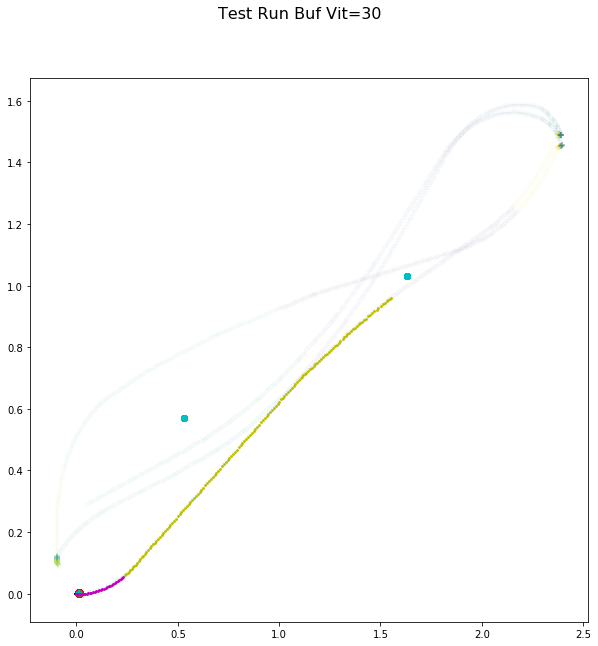

In [121]:
cc=ccxyth
paths= viterbi(obs_windowed,Modelo2,Modelo2.PI)
path=paths[int(-len(paths)/2):]
path_bigdelay = paths[:int(-len(paths)/2)]
cords= path_to_xy(path,cc)
cords_bigdelay = path_to_xy(path_bigdelay,cc)
cords1=path_to_xy(est_windowed.T[int(-len(paths)/2):],cc)
cords1delay=path_to_xy(est_windowed.T[:int(-len(paths)/2)],cc)



fig = plt.figure(figsize=(10,10))
fig.suptitle('Test Run Buf Vit=30', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0313)

ax1.scatter(x=cords.xcuant, y=cords.ycuant, marker='o',c='r',s=52,alpha=.5 )
ax1.scatter(x=cords_bigdelay.xcuant, y=cords_bigdelay.ycuant, marker='+',c='r',s=52,alpha=.1 )
ax1.scatter(x=cords1.xcuant, y=cords1.ycuant, marker='o',c='c' ,alpha=.5)
ax1.scatter(x=cords1delay.xcuant, y=cords1delay.ycuant, marker='+',c='c' ,alpha=.1)



ax1.scatter(x= odomreal.x[int(-len(paths)/2):], y=odomreal.y[int(-len(paths)/2):],marker='.',s=13,c='y')
ax1.scatter(x= odomreal.x[:int(-len(paths)/2)], y=odomreal.y[:int(-len(paths)/2)],marker='.',s=13,c='m')



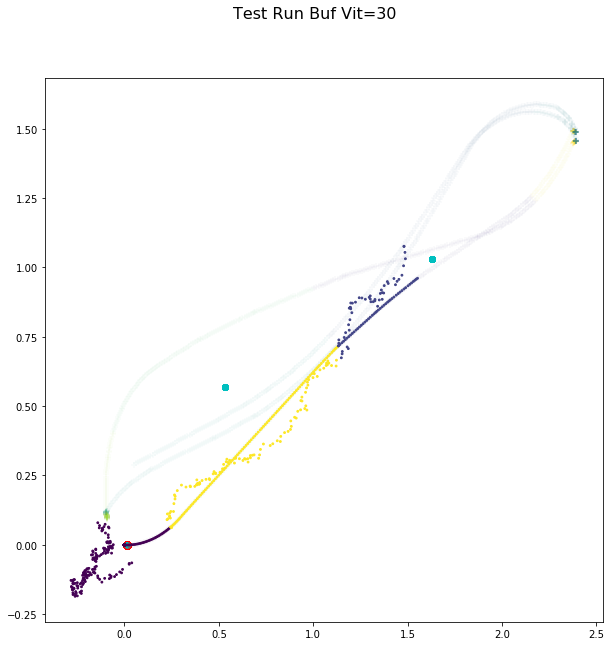

In [122]:
cc=ccxyth
paths= viterbi(obs_windowed,Modelo1,Modelo1.PI)
path=paths[int(-len(paths)/2):]
path_bigdelay = paths[:int(-len(paths)/2)]
cords= path_to_xy(path,cc)
cords_bigdelay = path_to_xy(path_bigdelay,cc)
cords1=path_to_xy(est_windowed.T[int(-len(paths)/2):],cc)
cords1delay=path_to_xy(est_windowed.T[:int(-len(paths)/2)],cc)



fig = plt.figure(figsize=(10,10))
fig.suptitle('Test Run Buf Vit=30', fontsize=16)

ax1 = fig.add_subplot(111)
ax1.scatter(x= data.x, y=data.y,marker='+',c=data.Y,alpha=.0313)

ax1.scatter(x=cords.xcuant, y=cords.ycuant, marker='o',c='r',s=52,alpha=.5 )
ax1.scatter(x=cords_bigdelay.xcuant, y=cords_bigdelay.ycuant, marker='+',c='r',s=52,alpha=.1 )
ax1.scatter(x=cords1.xcuant, y=cords1.ycuant, marker='o',c='c' ,alpha=.5)
ax1.scatter(x=cords1delay.xcuant, y=cords1delay.ycuant, marker='+',c='c' ,alpha=.1)



ax1.scatter(x= odomreal.x, y=odomreal.y,marker='.',s=13,c=states_odomreal)
ax1.scatter(x= odomnoisy.x_noise, y=odomnoisy.y_noise,marker='.',s=13,c=states_odomnoisy)

